In [1]:
import numpy as np
import pandas as pd

import pyopentd as pt

# 解析実行

In [3]:
# TDモデルの読み込み
dwg_path = "./td_model/sample.dwg"
td = pt.ThermalDesktop(dwg_path)

In [4]:
# ケースセットの一覧確認
casesets = td.get_casesets()
casesets.head()

,group_name,caseset_name,orbit_name,original_object
0,chamber,Case Set 0,,<pyopentd.main.Case object at 0x00000283F7A0AE50>
1,chamber,steady,,<pyopentd.main.Case object at 0x00000283F7A0AF40>
2,chamber,No rad,,<pyopentd.main.Case object at 0x00000283F7A0A4F0>
3,orbit,Case Set 2,sample_orbit,<pyopentd.main.Case object at 0x000002841AFBA5E0>


In [5]:
# ケースセットの読み込み
# orbit.Case Set 2 以外は動かないので注意。
group_name = 'orbit'
caseset_name = 'Case Set 2'
case = td.get_caseset(caseset_name, group_name)

In [6]:
# 軌道情報の取得
orbit_name = case.get_orbit_name()
print(orbit_name)
df_orbit = td.get_orbit(orbit_name)
df_orbit.head()

sample_orbit


,Times,sun_x,sun_y,sun_z,planet_x,planet_y,planet_z,radius
0,0.000000,0.0,0.0,1.0,0.0,-1.066924e-13,-1.000000e+00,1.078393
1,473.081495,0.0,0.0,1.0,0.0,5.000000e-01,-8.660254e-01,1.078393
2,946.162989,0.0,0.0,1.0,0.0,8.660254e-01,-5.000000e-01,1.078393
3,1419.244484,0.0,0.0,1.0,0.0,1.000000e+00,-1.331770e-13,1.078393
4,1765.927780,0.0,0.0,1.0,0.0,9.272846e-01,3.743571e-01,1.078393


In [6]:
# 実行
case.run()

# 結果出力

In [7]:
sav_name = case.origin.SindaOptions.SaveFilename
print(sav_name)

case2.sav


In [8]:
sav_path = f'./td_model/{case.origin.UserDirectory}/{sav_name}'
sav_path

'./td_model/output/case2.sav'

In [9]:
savefile = pt.SaveFile(sav_path)

In [10]:
df_temp = savefile.get_all_temperature().drop('Times', axis=1)
df_heat = savefile.get_all_heatrate().drop('Times', axis=1)

In [11]:
def get_attitude(t_list, df):
    attitude_list = []
    for t in t_list:
        attitude = np.zeros(6)
        T_orbit = df.iloc[-1]['Times']
        dt = df.iloc[-1]['Times'] - df.iloc[-2]['Times']
        t = t % T_orbit
        t_bef_index = t // dt
        t_af_index = t_bef_index + 1
        
        attitude_bef = df.iloc[int(t_bef_index)].values
        attitude_af = df.iloc[int(t_af_index)].values
        
        rate = (t % dt) / dt
        attitude = (1-rate)*attitude_bef + rate*attitude_af
        
        attitude_list.append(attitude[1:])
    
    return pd.DataFrame(attitude_list, columns=df.columns[1:])

In [12]:
df_orbit_modify = get_attitude(savefile.times, df_orbit)
# df_orbit_modify
df_time = pd.DataFrame(savefile.times, columns=['Times'])
df_case = pd.DataFrame([f'{case.origin.GroupName}.{case.origin.Name}']*len(savefile.times), columns=['case'])

In [13]:
df = pd.concat([df_case, df_time, df_orbit_modify, df_temp, df_heat], axis=1)
df.to_csv('sample_output.csv', index=False)

In [14]:
df.head(10)

,case,Times,sun_x,sun_y,sun_z,planet_x,planet_y,planet_z,radius,CHAMBER.T1,...,PANEL_PZ.Q1,PANEL_PZ.Q2,PANEL_PZ.Q3,PANEL_PZ.Q4,PANEL_PZ.Q5,PANEL_PZ.Q6,PANEL_PZ.Q7,PANEL_PZ.Q8,PANEL_PZ.Q9,SPACE.Q1
0,orbit.Case Set 2,0.0,0.0,0.0,1.0,0.0,-1.066924e-13,-1.000000,1.078393,20.0,...,2.459826,2.464066,2.468536,2.461092,2.460862,2.449824,2.466491,2.443034,2.436933,-32.531693
1,orbit.Case Set 2,120.0,0.0,0.0,1.0,0.0,1.268280e-01,-0.966017,1.078393,20.0,...,2.459058,2.464338,2.469239,2.460486,2.461182,2.450997,2.465678,2.443388,2.437949,-33.062472
2,orbit.Case Set 2,240.0,0.0,0.0,1.0,0.0,2.536561e-01,-0.932033,1.078393,20.0,...,2.458284,2.464612,2.469946,2.459877,2.461504,2.452177,2.464861,2.443744,2.438972,-33.558255
3,orbit.Case Set 2,360.0,0.0,0.0,1.0,0.0,3.804841e-01,-0.898050,1.078393,20.0,...,2.457489,2.464894,2.470673,2.459250,2.461836,2.453392,2.464020,2.444110,2.440024,-34.014743
4,orbit.Case Set 2,480.0,0.0,0.0,1.0,0.0,5.053529e-01,-0.860673,1.078393,20.0,...,2.456950,2.465406,2.471649,2.458877,2.462385,2.454806,2.463437,2.444683,2.441296,-34.434443
5,orbit.Case Set 2,600.0,0.0,0.0,1.0,0.0,5.981975e-01,-0.767828,1.078393,20.0,...,2.466426,2.475421,2.483090,2.468480,2.471933,2.464977,2.472922,2.453821,2.452047,-34.814243
6,orbit.Case Set 2,720.0,0.0,0.0,1.0,0.0,6.910420e-01,-0.674983,1.078393,20.0,...,2.475881,2.485412,2.494504,2.478061,2.481459,2.475124,2.482385,2.462937,2.462772,-35.151664
7,orbit.Case Set 2,840.0,0.0,0.0,1.0,0.0,7.838866e-01,-0.582139,1.078393,20.0,...,2.485349,2.495418,2.505936,2.487655,2.490999,2.485286,2.491861,2.472066,2.473514,-35.448359
8,orbit.Case Set 2,960.0,0.0,0.0,1.0,0.0,8.699440e-01,-0.485376,1.078393,20.0,...,2.495036,2.505565,2.517359,2.497492,2.500893,2.495666,2.501560,2.481488,2.484369,-35.705923
9,orbit.Case Set 2,1080.0,0.0,0.0,1.0,0.0,9.039275e-01,-0.358548,1.078393,20.0,...,2.507256,2.517392,2.528827,2.510133,2.514830,2.508587,2.513834,2.494258,2.496613,-35.922493


<Axes: xlabel='Times'>

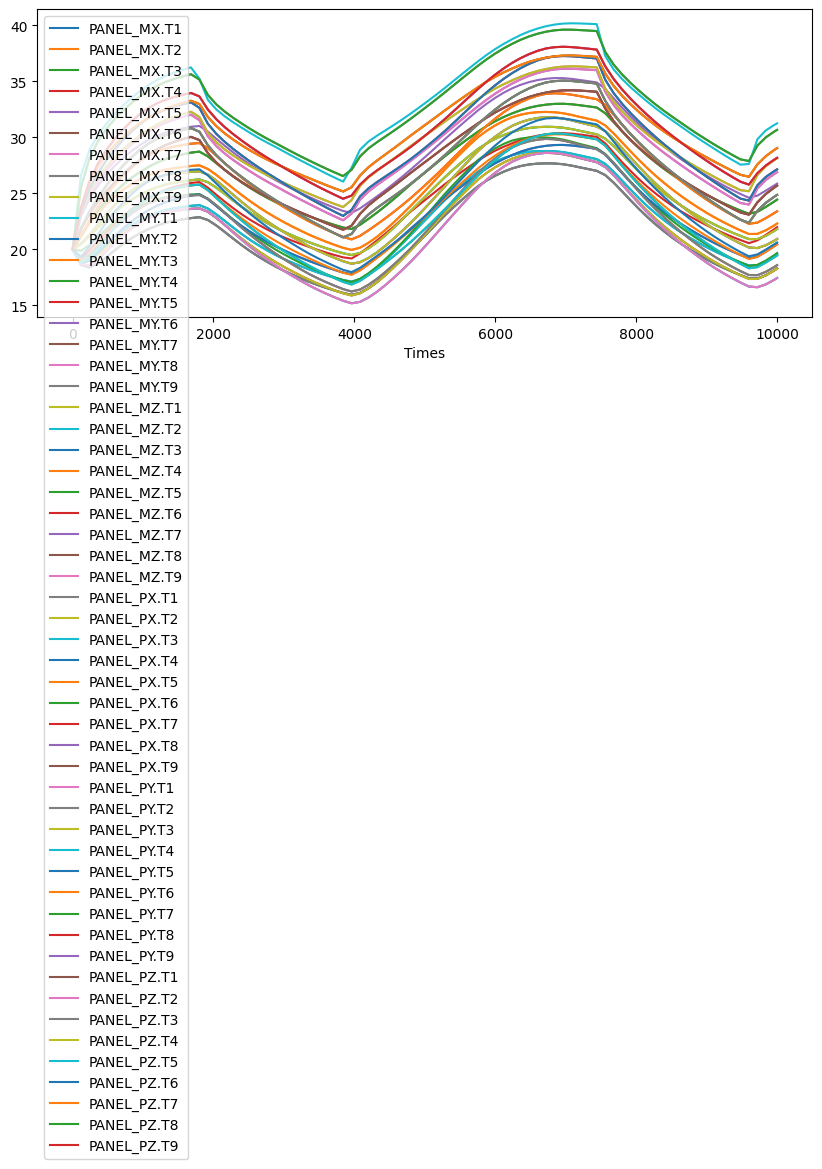

In [16]:
t_list = [s for s in df.columns if '.T' in s]
t_list = [s for s in t_list if not 'CHAMBER' in s]
t_list.remove('SPACE.T1')
df[['Times']+t_list].plot(x='Times', figsize=(10,4))